In [1]:
using Pkg
Pkg.activate(joinpath(Pkg.devdir(),"TaskGraphs"));

In [2]:
using TaskGraphs

┌ Info: Recompiling stale cache file /home/kylebrown/.julia/compiled/v1.0/TaskGraphs/apcwx.ji for TaskGraphs [6635cb54-791c-11e9-2805-8512ad3937f9]
└ @ Base loading.jl:1190


In [3]:
using CRCBS
using LightGraphs, MetaGraphs
using LinearAlgebra
using DataStructures
# using JuMP, MathOptInterface
# using Gurobi
using TOML
using Random

using GraphUtils

In [196]:
include(joinpath(dirname(pathof(TaskGraphs)),"..","test","notebooks","render_tools.jl"));

┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│   /home/kylebrown/.julia/dev/TaskGraphs/src/task_graphs_core.jl
└ @ Revise /home/kylebrown/.julia/packages/Revise/0KQ7U/src/Revise.jl:622
┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│   /home/kylebrown/.julia/dev/TaskGraphs/src/task_graphs_core.jl
└ @ Revise /home/kylebrown/.julia/packages/Revise/0KQ7U/src/Revise.jl:622


# Experiments:

Generate 4 environments for all experiments

In [ ]:
# env_graphs = []
# envs = []
# num_obstacle_cells = 64
# for (i,n) in enumerate([2,4,8])
#     obs_w = Int(sqrt(num_obstacle_cells)/n)
#     env = construct_regular_factory_world(;
#         n_obstacles_x=n,
#         n_obstacles_y=n,
#         obs_width = [obs_w;obs_w],
#         obs_offset = [obs_w;obs_w],
#         env_pad = [1;1],
#         env_offset = [1,1],
#         env_scale = 1 # this is essentially the robot diameter
#     )
#     filename = string(TaskGraphs.ENVIRONMENT_DIR,"/env_",i,".toml")
#     open(filename,"w") do io
#         TOML.print(io,env)
#     end
#     # graphics_filename = string(TaskGraphs.ENVIRONMENT_DIR,"/env_",i,".svg")
#     # visualize_env(env) |> SVG(graphics_filename)
#     push!(envs, env)
# end

In [ ]:
i = 2;
set_default_plot_size(10cm,10cm);
filename = string(TaskGraphs.ENVIRONMENT_DIR,"/env_",i,".toml");
factory_env = read_env(filename);
env_graph = factory_env;
dist_matrix = get_dist_matrix(env_graph);
p = visualize_env(factory_env)
# p |> PDF(joinpath("/home/kylebrown/Repositories/task_graphs_icra_paper/graphics","env_graph.pdf"))

# Record Video

In [ ]:
problem_id = 3
results_filename = joinpath(Pkg.devdir(),"TaskGraphs","dummy_results_dir","SparseAdjacencyMILP",string(:full_solver),string("results",problem_id,".toml"))
toml_dict = TOML.parsefile(results_filename);
robot_paths = Vector{Vector{Int}}(toml_dict["robot_paths"]);
object_paths = Vector{Vector{Int}}(toml_dict["object_paths"]);
object_intervals = Vector{Vector{Int}}(toml_dict["object_intervals"]);
tf = maximum(map(p->length(p),robot_paths))
set_default_plot_size(18cm,18cm)
record_video(joinpath(VIDEO_DIR,string("problem",problem_id,".webm")),
    t->render_paths(t,robot_paths,object_paths;object_intervals=object_intervals);tf=tf)

# Load results into dataframes

In [ ]:
N_problems = 384
problem_dir = PROBLEM_DIR
results_dir = RESULTS_DIR
# results_dir = joinpath(EXPERIMENT_DIR,"adjacency_solver/results")
config_df = construct_config_dataframe(problem_dir,N_problems);

In [ ]:
df_dict = construct_result_dataframes(problem_dir,results_dir,N_problems)

# Display experimental results

In [9]:
set_default_plot_size(28cm,12cm)

In [ ]:
# p1 = robots_vs_task_vs_time_box_plot(df_dict[:full_solver]; 
#     title="Full Algorithm")
# # p1 |> PDF("FullAlgorithm.pdf", 20cm, 12cm)
# # p1

In [178]:
N_problems = 192
problem_dir = joinpath(PROBLEM_DIR,"collaborative_transport")
results_dir = joinpath(EXPERIMENT_DIR,"sparse_adjacency_solver/collaborative_transport_dist_maps/results")
# results_dir = joinpath(EXPERIMENT_DIR,"sparse_adjacency_solver/collaborative_transport/results")
df_dict = construct_result_dataframes(problem_dir,results_dir,N_problems);
preprocess_collab_results!(df_dict);

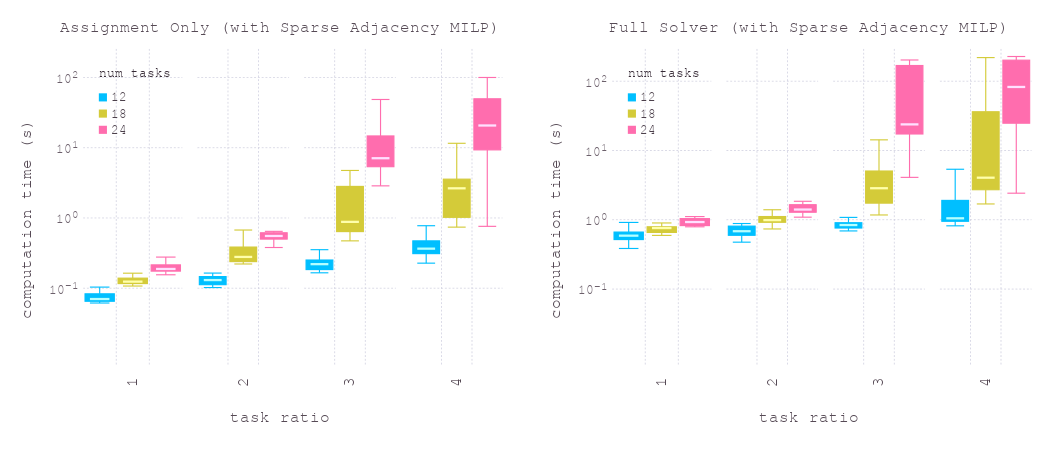

In [181]:
p1 = hstack(
    plot_collab_results(
            df_dict[:assignment_only]; 
            title="Assignment Only (with Sparse Adjacency MILP)",big_font=12pt,small_font=10pt),
    plot_collab_runtimes(
            df_dict[:full_solver]; 
            title="Full Solver (with Sparse Adjacency MILP)",big_font=12pt,small_font=10pt)
    )

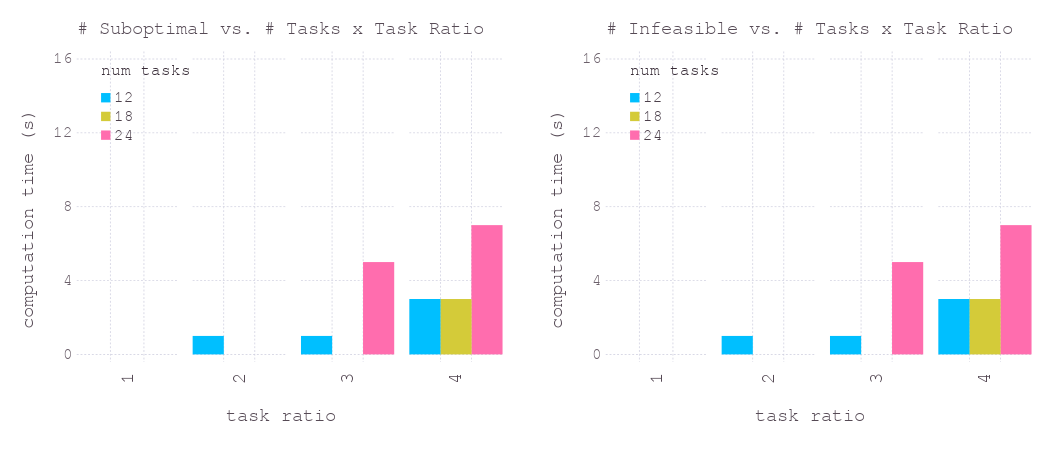

In [182]:
hstack(
    plot_collab_counts(df_dict[:full_solver];key=df_dict[:full_solver].optimal,
        title="# Suboptimal vs. # Tasks x Task Ratio"),
    plot_collab_counts(df_dict[:full_solver];key=df_dict[:full_solver].feasible,
        title="# Infeasible vs. # Tasks x Task Ratio")
)

In [171]:
function preprocess_collab_results!(df_dict)
    num_tasks = [12,18,24]
    num_robots = [24]
    depth_biases=[0.1]
    task_size_distributions = [1,2,3,4]
    num_trials=16
    task_ratios = Int[]
    for (M,N,task_sizes,trial) in Base.Iterators.product(
            num_tasks,num_robots,task_size_distributions,1:num_trials
            )
        push!(task_ratios, task_sizes)
    end
    
    for (k,df) in df_dict
        if nrow(df) > 0
            begin df[!,:depth_bias_string] = string.(df.depth_bias)
                df
            end
            begin df[!,:N_string] = string.(df.N)
                df
            end
            begin df[!,:M_string] = string.(df.M)
                df
            end
            begin df[!,:TaskRatio] = task_ratios[df.problem_id]
                df
            end
        end
    end
    df_dict
end
function plot_collab_runtimes(df;
        title="Solution time by Number of Tasks (M) and ratio of tasks (task ratio )",
        yticks=[-1,0,1,2],
        ymin=-1.5,
        ymax=2.3,
        y_bounds=[0.01,100.0],
        big_font=14pt,
        small_font=12pt,
        xgroup=:TaskRatio,
        x=:M_string,
        y=:time
    )
    latex_fonts = Theme(major_label_font="CMU Serif", major_label_font_size=big_font,
                    minor_label_font="CMU Serif", minor_label_font_size=small_font,
                    key_title_font="CMU Serif", key_title_font_size=small_font,
                    key_label_font="CMU Serif", key_label_font_size=small_font)
    
    plot(df, xgroup=xgroup, x=x, y=y, color=x,
        Geom.subplot_grid(
            Geom.boxplot(;suppress_outliers=true),
            Coord.cartesian(; ymin=ymin, ymax=ymax),
            Guide.yticks(;ticks=yticks),
            Guide.xticks(;label=false),
            ),
        Guide.title(title),
        Guide.colorkey(title="num tasks", labels=["12","18","24"], pos=[0.1w,-0.32h]),
#         Scale.group_discrete(labels=M->string(M," Tasks"),levels=[1,2,3,4]),
        Guide.xlabel("task ratio"),
        Guide.ylabel("computation time (s)"),
        Scale.y_log10(minvalue=y_bounds[1],maxvalue=y_bounds[2]),
        latex_fonts
    )
end
function plot_collab_counts(df;
        title="# failures vs. # Tasks (M) x Task Ratio",
        yticks=[0,4,8,12,16],
        ymin=0,
        ymax=16,
        y_bounds=[0.01,100.0],
        big_font=14pt,
        small_font=12pt,
        task_ratios = [
            ( 1=>1.0, 2=>0.0, 4=>0.0 ),
            ( 1=>1.0, 2=>1.0, 4=>0.0 ),
            ( 1=>1.0, 2=>1.0, 4=>1.0 ),
            ( 1=>0.0, 2=>1.0, 4=>1.0 ),
        ],
        key=df.optimal
    )
    
    
    opt_df = DataFrame( M = Int[], task_ratio = Int[], num_no = Int[], num_yes = Int[] )

    for (i,ratio) in enumerate(task_ratios)
        for m in Set(collect(df.M))
        push!(
            opt_df,
            Dict(
                :M =>m,
                :task_ratio => i,
                :num_no => nrow(df[(df.M .== m) .* (df.TaskRatio .== i) .* (key .== false),:]),
                :num_yes => nrow(df[(df.M .== m) .* (df.TaskRatio .== i) .* (key .== true),:]),
            )
        )
        end
    end
    begin opt_df[!,:M_string] = string.(opt_df.M)
        opt_df
    end
    
    latex_fonts = Theme(major_label_font="CMU Serif", major_label_font_size=big_font,
                    minor_label_font="CMU Serif", minor_label_font_size=small_font,
                    key_title_font="CMU Serif", key_title_font_size=small_font,
                    key_label_font="CMU Serif", key_label_font_size=small_font)
    
    plot(opt_df, xgroup=:task_ratio, x=:M_string, y=:num_no, color=:M_string,
        Geom.subplot_grid(
            Geom.bar,
            Coord.cartesian(; ymin=ymin, ymax=ymax),
            Guide.yticks(;ticks=yticks),
            Guide.xticks(;label=false),
            ),
        Guide.title(title),
        Guide.colorkey(title="num tasks", labels=["12","18","24"], pos=[0.1w,-0.32h]),
        Scale.group_discrete(labels=M->string(M," Tasks"),levels=[1,2,3,4]),
        Guide.xlabel("task ratio"),
        Guide.ylabel("computation time (s)"),
        latex_fonts
    )
end

plot_collab_counts (generic function with 1 method)

┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│   /home/kylebrown/.julia/dev/TaskGraphs/src/task_graphs_core.jl
└ @ Revise /home/kylebrown/.julia/packages/Revise/0KQ7U/src/Revise.jl:622
┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│   /home/kylebrown/.julia/dev/TaskGraphs/src/task_graphs_core.jl
└ @ Revise /home/kylebrown/.julia/packages/Revise/0KQ7U/src/Revise.jl:622


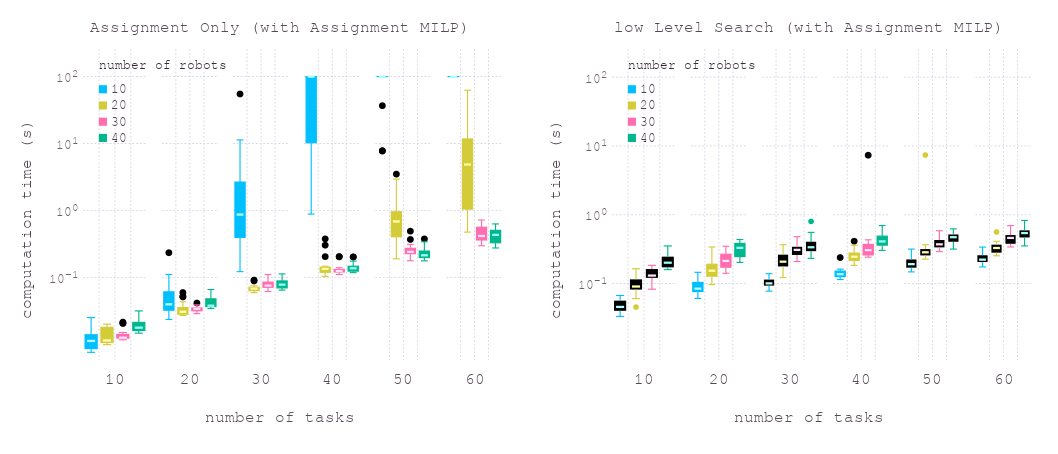

In [199]:
N_problems = 384
problem_dir = PROBLEM_DIR
# results_dir = RESULTS_DIR
results_dir = joinpath(EXPERIMENT_DIR,"assignment_solver/results")
df_dict1 = construct_result_dataframes(problem_dir,results_dir,N_problems)
preprocess_results!(df_dict1)
p1 = hstack(
    robots_vs_task_vs_time_box_plot(
        df_dict1[:assignment_only]; 
        title="Assignment Only (with Assignment MILP)",big_font=12pt,small_font=10pt),
    robots_vs_task_vs_time_box_plot(
        df_dict1[:low_level_search_without_repair]; 
        title="low Level Search (with Assignment MILP)",big_font=12pt,small_font=10pt)
    )

┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│   /home/kylebrown/.julia/dev/TaskGraphs/src/task_graphs_core.jl
└ @ Revise /home/kylebrown/.julia/packages/Revise/0KQ7U/src/Revise.jl:622
┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│   /home/kylebrown/.julia/dev/TaskGraphs/src/task_graphs_core.jl
└ @ Revise /home/kylebrown/.julia/packages/Revise/0KQ7U/src/Revise.jl:622


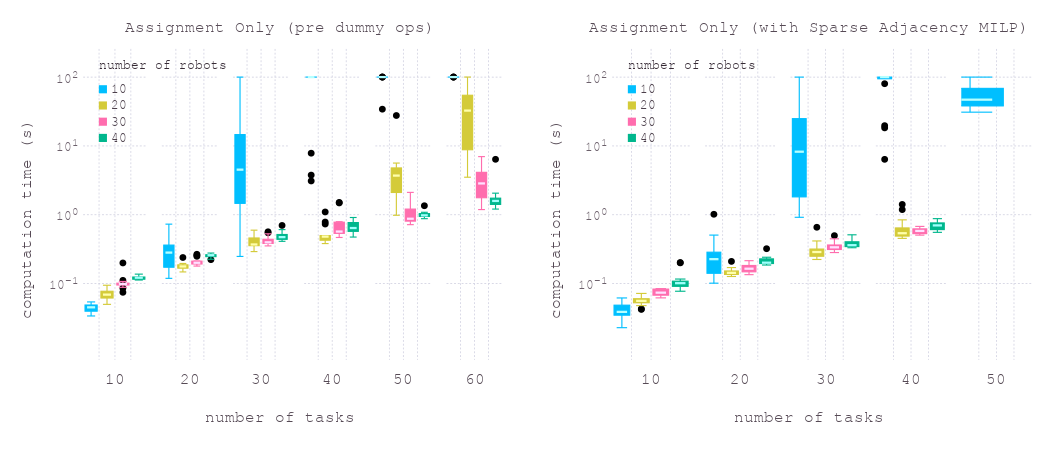

In [198]:
N_problems = 384
problem_dir = PROBLEM_DIR
# results_dir = joinpath(EXPERIMENT_DIR,"assignment_solver/results")
results_dir = joinpath(EXPERIMENT_DIR,"sparse_adjacency_solver/results")
df_dict1 = construct_result_dataframes(problem_dir,results_dir,N_problems)
preprocess_results!(df_dict1)
results_dir = joinpath(EXPERIMENT_DIR,"sparse_adjacency_solver/dummy_ops/results")
df_dict2 = construct_result_dataframes(problem_dir,results_dir,N_problems)
preprocess_results!(df_dict2)
p1 = hstack(
    robots_vs_task_vs_time_box_plot(
        df_dict1[:assignment_only]; 
#         title="Assignment Only (with Assignment MILP)",big_font=12pt,small_font=10pt),
        title="Assignment Only (pre dummy ops)",big_font=12pt,small_font=10pt),
    robots_vs_task_vs_time_box_plot(
        df_dict2[:assignment_only]; 
        title="Assignment Only (with Sparse Adjacency MILP)",big_font=12pt,small_font=10pt)
    )

In [ ]:
p3 |> SVG("SparseMILP.svg", 20cm, 12cm)

In [ ]:
# set_default_plot_size(20cm,9cm)
# p3 = robots_vs_task_vs_time_box_plot(
#     df_dict[:low_level_search_with_repair];title=nothing,yticks=[-1,0,1],ymin=-1.5,ymax=0.2)

In [ ]:
using PGFPlotsX
latexengine!(PGFPlotsX.PDFLATEX)
using Printf

In [ ]:
function get_runtime_box_plot(df;obj=:time,m_range=10:10:60,n_range=10:10:40,ymin=0.007,title="",nsym="n",msym="m",)
    @pgf gp = GroupPlot({group_style = { 
                "group name"="myPlots",
                "group size"="6 by 1",
                "xlabels at"="edge bottom",
                "xticklabels at"="edge bottom",
                "vertical sep"="0pt",
                "horizontal sep"="2pt"
            },
            boxplot,
            "boxplot/draw direction"="y",
            # axis lines=left,
            # hide axis,
            ymode="log",
            footnotesize,
            width="3.25cm",
            height="6cm",
            xmin=0, 
            xmax=5,
            ymin=ymin,
            ymax=120,
            xtick=[10,20,30,40],
            xticklabels=[10,20,30,40],
            tickpos="left",
            ytick=[0.1,1,10,100],
            yticklabels=[],
            "ylabel shift"="0pt",
            "ytick align"="outside",
            "xtick align"="outside"});

    @pgf for (i,m) in enumerate(m_range)
        if i == 1
            push!(gp, 
                {xlabel=@sprintf("\$%s=%i\$",msym,m),
                ylabel="time (s)",
                yticklabels=[0.1,1,10,100],
                "legend style"="{draw=none,xshift=2pt}",
                "legend pos"="north west"},
                map(n->LegendEntry({},@sprintf("\$%s=%i\$",nsym,n),false),n_range)...,
                """
                \\addlegendimage{no markers,blue}
                \\addlegendimage{no markers,red}
                \\addlegendimage{no markers,brown}
                \\addlegendimage{no markers,black}
                """,
                map(n->PGFPlotsX.PlotInc({boxplot},Table(
                            {"y index"=0},
                            [:data=>df[(df.M .== m) .& (df.N .== n),obj]])),n_range)...)
        else
            push!(gp, {xlabel=@sprintf("\$%s=%i\$",msym,m)}, 
                map(n->PGFPlotsX.PlotInc({boxplot},Table(
                            {"y index"=0},
                            [:data=>df[(df.M .== m) .& (df.N .== n),obj]])),n_range)...)
        end
    end;
    if title != ""
        tikzpic = @pgf TikzPicture({scale=0.7},
            """
            \\centering
            """,
            gp,
            @sprintf("""
            \\node (title) at (\$(myPlots c1r1.center)!0.5!(myPlots c2r1.center)+(3.3cm,2.55cm)\$) {\\textbf{%s}};
            """,title)
        )
    else
        tikzpic = @pgf TikzPicture({scale=0.7},
            """
            \\centering
            """,
            gp
        )
    end
    return tikzpic
end

# print_tex(gp)

In [ ]:
# mode_list = [:full_solver,:assignment_only,:low_level_search_without_repair,:low_level_search_with_repair]
mode_list = [:full_solver]
tmin = minimum(map(MODE->minimum(df_dict[MODE].time),mode_list))

In [ ]:
# gp = get_runtime_box_plot(df_dict[:full_solver];ymin=tmin)

In [ ]:
# titles = Dict(
#     :full_solver => "Runtime of Full \\PCTAPF{} Solver",
#     :assignment_only => "Runtime of Task Assignment MILP Solver",
#     :low_level_search_with_repair => "Runtime of \\LevelThreeLong{}",
#     :low_level_search_without_repair => "Runtime of \\LevelThreeLong{}",
# )
titles = Dict(
    :full_solver => "Experimental Results (Runtime)",
    :assignment_only => "",
    :low_level_search_with_repair => "",
    :low_level_search_without_repair => "",
)
for MODE in [:full_solver,:assignment_only,:low_level_search_without_repair,:low_level_search_with_repair]
    gp = get_runtime_box_plot(df_dict[MODE];ymin=tmin,title=titles[MODE])
#     open(joinpath("/home/kylebrown/Repositories/task_graphs_icra_paper/graphics",string(MODE,".tex")),"w") do io
    open(string(MODE,".tex"),"w") do io
        print_tex(io, gp)
    end
end